In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from docplex.mp.model import Model
# from NPG_CMDP import CMDP_NPG
# from ARNPG_CMDP import CMDP_ARNPG
from MARL import MARL_agent, MO_MARL

# Random Seed
np.random.seed(10)

In [2]:
def global_to_local(global_action):
    temp = global_action
    local_actions = np.zeros(n)
    for agent in range(n):
        local_actions[agent] = temp%a
        temp = int(temp/a)
    return local_actions


def is_next_safe(state, global_action):
    if state>=a**n:
        cur_safe = True
    else:
        cur_safe = False
    local_actions = global_to_local(global_action)
    count_area = np.zeros(a)
    for action in local_actions:
        count_area[int(action)]+=1
    if np.max(count_area)<=n/a:
        return True
    if np.max(count_area)<=3 and cur_safe:
        return True
    else:
        return False

def state_reward(state):
    if state>=a**n:
        cur_safe = True
        state -= a**n
    else:
        cur_safe = False
    local_positions = global_to_local(state)
    count_area = np.zeros(a)
    for pos in local_positions:
        count_area[int(pos)]+=1
    reward = np.dot(count_area, weight)
    if not cur_safe:
        reward -= c*n
    return reward

In [3]:
from MARL import MARL_agent
n = 4
a = 2
s = 2*a**n
gamma = 0.8

weight = [1,2]
c = 1
A = a**n

# Randomly generated probability transition matrix P((s,a) -> s') in [0,1]^{|S||A| x |S|}
# raw_transition = np.random.uniform(0, 1, size=(s * A, s))
raw_transition = np.zeros(shape=(s * A, s))

for state in range(s):
    for global_action in range(A):
        next_state = global_action
        if is_next_safe(state, global_action):
            next_state+=a**n
        raw_transition[state*A+global_action, next_state] = 1

# raw_transition = np.ones((s * A, s))
prob_transition = raw_transition / raw_transition.sum(axis=1, keepdims=1)
print(np.max(prob_transition-raw_transition))
# Random positive rewards
# reward = np.random.uniform(0, 1, size=(s * A))
reward = np.zeros(shape=(s * A))
for state in range(s):
    for global_action in range(A):
        reward[state*A+global_action] = state_reward(state)

rewards = [reward]
print(reward)
# Start state distribution
rho = np.ones(s) / s

0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 5. 5. 5. 5. 5. 5. 5. 5

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 51.02it/s]


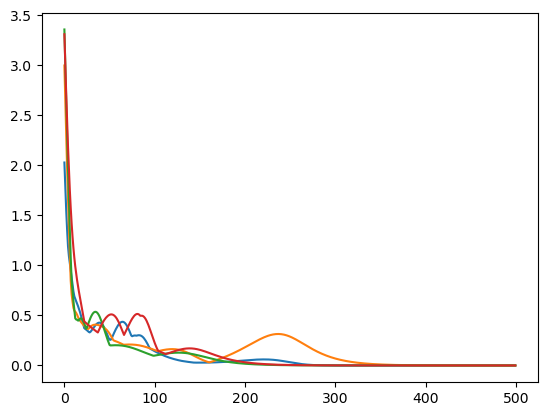

In [4]:
temp = MARL_agent(rewards, s, a, rho, gamma, n, prob_transition, tau=0.1)
temp.tau = 0
temp.step = 0.01
# temp.theta = np.zeros(shape=n* s* a)
temp.theta = np.random.randn(n* s* a)
prob_record = []
NEgaps = []
N = 500
for i in tqdm(range(N)):
#   temp.NPG_entropy_step(verbose=False)
    A_tildes, pi, Pi_global, V_tau, A_tau = temp.NPG_entropy_step_change(verbose=False)
    prob_record.append(pi)
    NEgap = []
    for A_tilde in A_tildes:
        NEgap.append(np.max(A_tilde))
    NEgaps.append(NEgap)
# print(A_tildes)
# print(pi.shape)
# plt.plot(temp.gap)
plt.plot(NEgaps)
# Q_global_star = np.copy(temp.Q_global[-1])
# # Q_global: s*A

# Q_tilde_star = np.copy(temp.Q_tilde[-1])
# pi_star = np.copy(pi)
# Pi_global_star = np.copy(Pi_global)

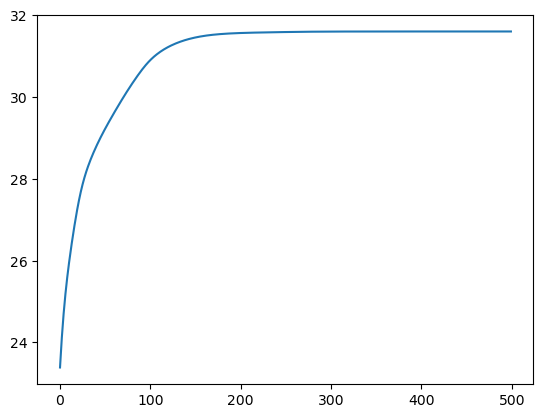

In [5]:
plt.plot(temp.gap)
